In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import os

# Settings
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

RANDOM_STATE = 42

## Load Data

EDA is performed on training data only. Test set is held out until final evaluation.

In [6]:
# Load splits
train_df = pd.read_csv('../Datasets/voiceai_intent_train.csv')
val_df = pd.read_csv('../Datasets/voiceai_intent_val.csv')
test_df = pd.read_csv('../Datasets/voiceai_intent_test.csv')

# Load data dictionary
with open('../Datasets/voiceai_intent_data_dictionary.json', 'r') as f:
    data_dict = json.load(f)

print(f"Train: {len(train_df)} samples (used for EDA & training)")
print(f"Val:   {len(val_df)} samples (used in cross-validation)")
print(f"Test:  {len(test_df)} samples (held out until final evaluation)")

Train: 561 samples (used for EDA & training)
Val:   70 samples (used in cross-validation)
Test:  69 samples (held out until final evaluation)


In [7]:
# Preview training data
train_df.head(10)

,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00159,2025-11-07T15:32:00,whatsapp_voice_note,feature_phone,Western,en,What are the requirements for ID replacement?,0.902,9,requirements_information,train
1,utt_00501,2025-11-12T10:41:00,voice_call,android,Kigali,en,Am I eligible to apply for ESIA?,0.644,7,service_eligibility,train
2,utt_00397,2025-11-28T17:58:00,ivr,web,Eastern,mixed,Help me reset password yanjye.,0.964,9,reset_password_login_help,train
3,utt_00156,2025-11-25T19:52:00,voice_call,web,Southern,en,I submitted my aplikasiyo but I can't see the status.,0.911,2,check_application_status,train
4,utt_00322,2025-11-24T00:46:00,voice_call,feature_phone,Eastern,en,I want to start a new application for birth certificate.,0.810,10,start_new_application,train
5,utt_00213,2025-11-06T23:34:00,mobile_app_voice,android,Eastern,en,What are the requirements for ESIA?,0.942,7,requirements_information,train
6,utt_00235,2025-11-22T09:16:00,voice_call,web,Eastern,en,What are the requirements for driving license?,0.881,7,requirements_information,train
7,utt_00290,2025-11-24T21:29:00,voice_call,ios,Western,en,I paid but it is not confirmed.,0.814,7,payment_help,train
8,utt_00301,2025-10-13T01:54:00,voice_call,feature_phone,Kigali,en,Am I eligible to apply for driving license?,0.821,9,service_eligibility,train
9,utt_00357,2025-12-07T16:36:00,whatsapp_voice_note,ios,Kigali,rw,"Nshaka gusaba attestation y’imisoro, ntangira he?",0.823,4,start_new_application,train


In [19]:
# Preview validation data
val_df.head(10)

,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00037,2025-10-08T19:45:00,voice_call,ios,Western,en,How do I begin an application for driving license?,0.972,2,payment_help,val
1,utt_00184,2025-10-26T01:34:00,voice_call,android,Kigali,rw,Uburyo bwo kwishyura tax clearance ni ubuhe?,0.807,5,payment_help,val
2,utt_00130,2025-12-08T16:41:00,mobile_app_voice,android,Northern,mixed,Nashaka gufata appointment ya ESIA i Muhanga.,0.695,5,appointment_booking,val
3,utt_00551,2025-09-28T20:32:00,mobile_app_voice,web,Northern,mixed,Nishyuye but ntabwo byemejwe.,0.885,5,payment_help,val
4,utt_00538,2025-10-17T20:13:00,whatsapp_voice_note,ios,Kigali,rw,Ndashaka booking yigihe kuri gusimbuza indangamuntu.,0.864,6,appointment_booking,val
5,utt_00268,2025-10-24T02:37:00,whatsapp_voice_note,web,Northern,en,What are the requirements for visa on arrival?,0.815,6,requirements_information,val
6,utt_00497,2025-12-22T23:08:00,ivr,ios,Kigali,rw,Ni nde wemerewe attestation y’imisoro?,0.812,5,service_eligibility,val
7,utt_00113,2025-10-01T09:36:00,whatsapp_voice_note,feature_phone,Kigali,rw,Uburyo bwo kwishyura permis ni ubuhe?,0.847,10,payment_help,val
8,utt_00318,2025-11-01T13:27:00,voice_call,ios,Eastern,mixed,Nishyuye but ntabwo byemejwe.,0.919,5,payment_help,val
9,utt_00411,2025-10-15T01:48:00,mobile_app_voice,ios,Western,en,What are the eligibility rules for marriage certificate?,0.929,4,service_eligibility,val


In [8]:
# Data types and missing values (training set only)
print("Data Types:")
print(train_df.dtypes)
print(f"\nMissing Values: {train_df.isnull().sum().sum()}")

Data Types:
utterance_id         object
timestamp            object
channel              object
device_type          object
region               object
language             object
utterance_text       object
asr_confidence      float64
duration_seconds      int64
intent               object
split                object
dtype: object

Missing Values: 0


## Fix Mislabelled Data

In [20]:
# Train set corrections
train_corrections = {
    'utt_00697': 'service_eligibility',
    'utt_00632': 'fees_information',
    'utt_00687': 'fees_information',
    'utt_00670': 'payment_help',
    'utt_00297': 'service_eligibility',
    'utt_00343': 'start_new_application',
    'utt_00587': 'reset_password_login_help',
    'utt_00465': 'requirements_information',
    'utt_00034': 'requirements_information',
    'utt_00172': 'start_new_application',
    'utt_00406': 'check_application_status',
    'utt_00417': 'speak_to_agent',
    'utt_00187': 'cancel_or_reschedule_appointment',
    'utt_00630': 'check_application_status',
}

# Validation set corrections
val_corrections = {
    'utt_00037': 'start_new_application',
}

# Apply to train_df
print("Fixing train_df...")
for utt_id, correct_intent in train_corrections.items():
    mask = train_df['utterance_id'] == utt_id
    if mask.sum() > 0:
        old_intent = train_df.loc[mask, 'intent'].values[0]
        train_df.loc[mask, 'intent'] = correct_intent
        print(f"  {utt_id}: {old_intent} → {correct_intent}")

# Apply to val_df
print("\nFixing val_df...")
for utt_id, correct_intent in val_corrections.items():
    mask = val_df['utterance_id'] == utt_id
    if mask.sum() > 0:
        old_intent = val_df.loc[mask, 'intent'].values[0]
        val_df.loc[mask, 'intent'] = correct_intent
        print(f"  {utt_id}: {old_intent} → {correct_intent}")

print(f"\nTotal train corrections: {len(train_corrections)}")
print(f"Total val corrections: {len(val_corrections)}")

Fixing train_df...
  utt_00697: check_application_status → service_eligibility
  utt_00632: speak_to_agent → fees_information
  utt_00687: appointment_booking → fees_information
  utt_00670: update_application_details → payment_help
  utt_00297: reset_password_login_help → service_eligibility
  utt_00343: service_eligibility → start_new_application
  utt_00587: fees_information → reset_password_login_help
  utt_00465: document_upload_help → requirements_information
  utt_00034: speak_to_agent → requirements_information
  utt_00172: fees_information → start_new_application
  utt_00406: reset_password_login_help → check_application_status
  utt_00417: requirements_information → speak_to_agent
  utt_00187: update_application_details → cancel_or_reschedule_appointment
  utt_00630: speak_to_agent → check_application_status

Fixing val_df...
  utt_00037: payment_help → start_new_application

Total train corrections: 14
Total val corrections: 1


## Intent (Label) Distribution

In [21]:
# Intent distribution on TRAINING set only
intent_counts = train_df['intent'].value_counts()
print(f"Number of intent classes: {len(intent_counts)}")
print(f"\nIntent distribution (training set):")
print(intent_counts)

Number of intent classes: 13

Intent distribution (training set):
intent
check_application_status            95
requirements_information            70
start_new_application               59
payment_help                        44
complaint_or_support_ticket         41
fees_information                    40
reset_password_login_help           40
service_eligibility                 37
appointment_booking                 37
update_application_details          29
speak_to_agent                      28
cancel_or_reschedule_appointment    24
document_upload_help                17
Name: count, dtype: int64


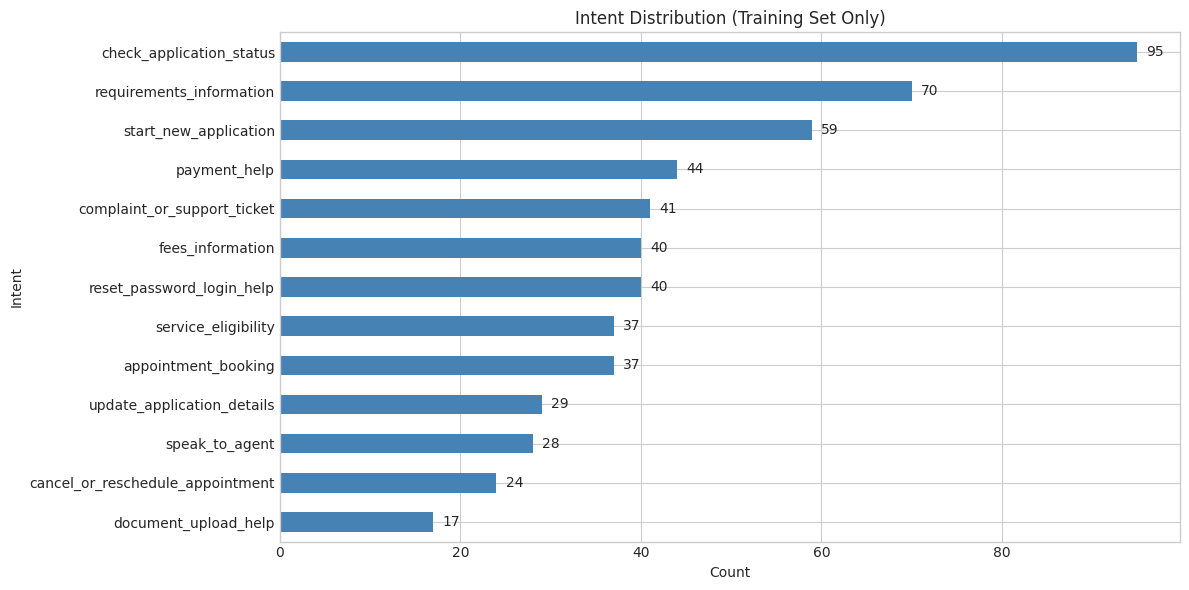

In [22]:
# Visualize intent distribution
fig, ax = plt.subplots(figsize=(12, 6))
intent_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Count')
ax.set_ylabel('Intent')
ax.set_title('Intent Distribution (Training Set Only)')
ax.invert_yaxis()

for i, v in enumerate(intent_counts.values):
    ax.text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.show()

In [23]:
# Class imbalance
max_class = intent_counts.max()
min_class = intent_counts.min()
print(f"Max class: {intent_counts.idxmax()} ({max_class} samples)")
print(f"Min class: {intent_counts.idxmin()} ({min_class} samples)")
print(f"Imbalance ratio: {max_class / min_class:.2f}x")

Max class: check_application_status (95 samples)
Min class: document_upload_help (17 samples)
Imbalance ratio: 5.59x


## Confidence Distribution


In [24]:
train_df['asr_confidence'].value_counts().sort_index(ascending=True)

asr_confidence
0.561     1
0.612     1
0.618     1
0.644     1
0.648     1
         ..
0.984     2
0.987     2
0.988     1
0.989     1
0.990    20
Name: count, Length: 248, dtype: int64

In [25]:
train_df[train_df['asr_confidence'] < 0.7]

,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
1,utt_00501,2025-11-12T10:41:00,voice_call,android,Kigali,en,Am I eligible to apply for ESIA?,0.644,7,service_eligibility,train
13,utt_00079,2025-12-19T10:31:00,ivr,web,Southern,rw,Nashaka gufata appointment kuri icyemezo cy’amavuko i Rusizi.,0.561,3,appointment_booking,train
15,utt_00571,2025-12-11T08:26:00,mobile_app_voice,web,Kigali,rw,Checka niba request yanjye yarangiye.,0.691,4,check_application_status,train
16,utt_00447,2025-10-13T00:58:00,mobile_app_voice,ios,Eastern,en,I submitted my applicashon but I can't see the status.,0.666,7,check_application_status,train
40,utt_00177,2025-10-21T17:40:00,ivr,android,Western,rw,Nkeneye gukora application nshya ya birth certificate.,0.678,9,start_new_application,train
80,utt_00205,2025-12-17T05:37:00,mobile_app_voice,android,Eastern,rw,Amabwiriza yo gusaba birth certificate ni ayahe?,0.695,7,requirements_information,train
94,utt_00071,2025-10-23T20:59:00,voice_call,web,Southern,en,My payment failed for passport. What should I do?,0.698,6,payment_help,train
99,utt_00166,2025-10-09T09:08:00,mobile_app_voice,android,Southern,mixed,Fee ya birth certificate ni angahe?,0.697,3,fees_information,train
144,utt_00546,2025-10-21T13:35:00,ivr,ios,Western,rw,Natanze application number ariko sinzi aho igeze.,0.662,7,check_application_status,train
164,utt_00586,2025-12-24T03:31:00,mobile_app_voice,ios,Eastern,en,Where is my application now?,0.665,5,check_application_status,train


## Language Distribution

In [26]:
# Language distribution on TRAINING set
lang_counts = train_df['language'].value_counts()
print("Language distribution (training set):")
for lang, count in lang_counts.items():
    pct = count / len(train_df) * 100
    print(f"  {lang}: {count} ({pct:.1f}%)")

Language distribution (training set):
  rw: 238 (42.4%)
  mixed: 164 (29.2%)
  en: 159 (28.3%)


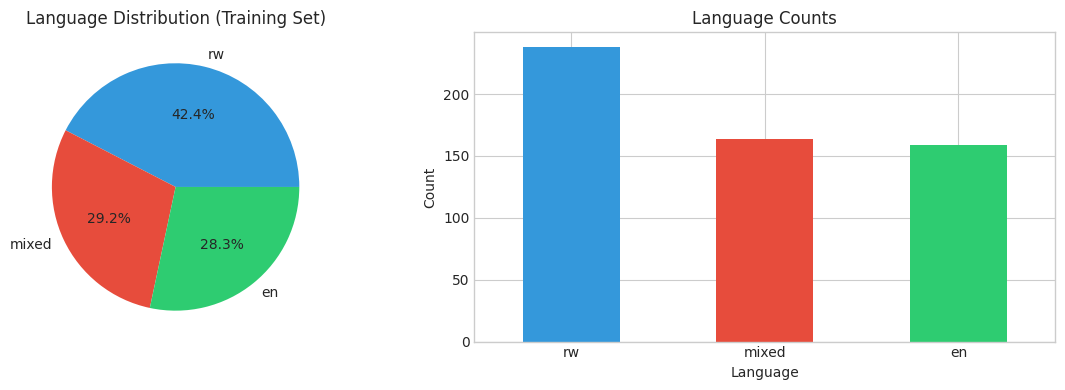

In [27]:
# Visualize language distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%', 
            colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Language Distribution (Training Set)')

lang_counts.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Language Counts')
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

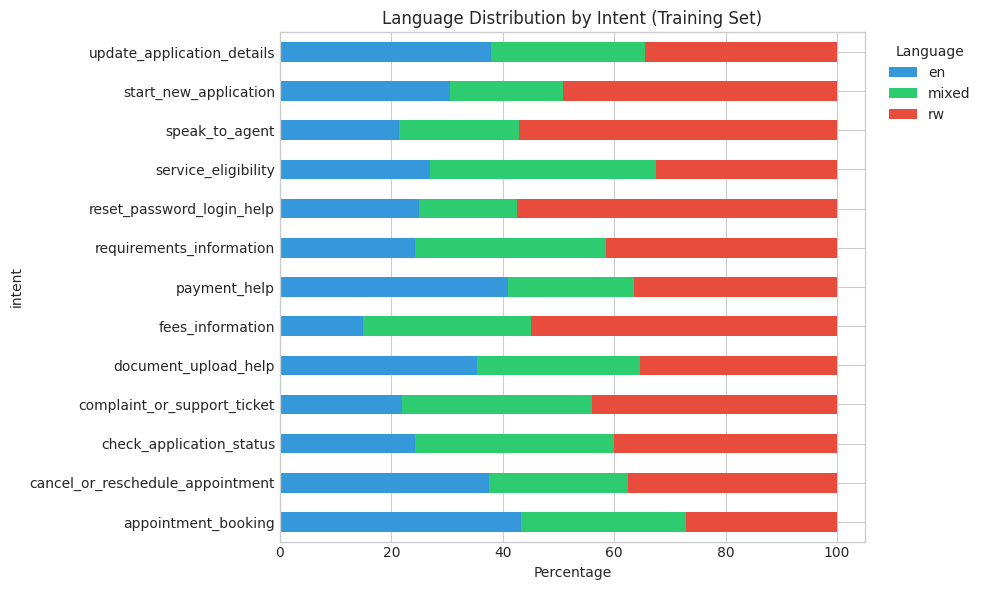

In [28]:
# Language by intent crosstab (training set)
lang_intent = pd.crosstab(train_df['intent'], train_df['language'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 6))
lang_intent.plot(kind='barh', stacked=True, ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_xlabel('Percentage')
ax.set_title('Language Distribution by Intent (Training Set)')
ax.legend(title='Language', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

## Utterance Analysis

In [29]:
# Utterance length statistics (training set)
train_df['utterance_length'] = train_df['utterance_text'].str.len()
train_df['word_count'] = train_df['utterance_text'].str.split().str.len()

print("Utterance Length (characters) - Training Set:")
print(train_df['utterance_length'].describe())
print("\nWord Count - Training Set:")
print(train_df['word_count'].describe())

Utterance Length (characters) - Training Set:
count    561.000000
mean      42.795009
std       10.148313
min       21.000000
25%       35.000000
50%       43.000000
75%       50.000000
max       71.000000
Name: utterance_length, dtype: float64

Word Count - Training Set:
count    561.000000
mean       6.495544
std        1.668104
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       12.000000
Name: word_count, dtype: float64


In [30]:
# Sample utterances by intent (training set)
print("Sample Utterances by Intent (Training Set):")
for intent in train_df['intent'].unique()[:5]:  # Show first 5 intents
    print(f"Intent: {intent}")
    samples = train_df[train_df['intent'] == intent].sample(min(3, len(train_df[train_df['intent'] == intent])), random_state=RANDOM_STATE)
    for _, row in samples.iterrows():
        print(f"  [{row['language']}] {row['utterance_text']}")

Sample Utterances by Intent (Training Set):
Intent: requirements_information
  [rw] Amabwiriza yo gusaba gusimbuza indangamuntu ni ayahe?
  [en] What are the requirements for ID replacement?
  [mixed] What documents nkeneye kuri kwandikisha ubucuruzi?
Intent: service_eligibility
  [mixed] Eligibility ya business registration ni iyihe?
  [rw] Ese icyemezo cy’ubukwe iba isabwa n’abantu b’iki cyiciro?
  [mixed] Eligibility ya birth certificate ni iyihe?
Intent: reset_password_login_help
  [en] I cannot log in to my account.
  [mixed] OTP ntabwo igeze, what can I do?
  [en] The OTP is not coming through.
Intent: check_application_status
  [rw] Ndashaka kumenya aho application number igeze.
  [en] Where is my application now?
  [rw] Ndashaka kureba status ya dossier yanjye.
Intent: start_new_application
  [en] I want to start a new application for birth certificate.
  [rw] Nshaka gusaba tax clearance, ntangira he?
  [mixed] Nshaka apply for business registration, ntangira he?


## Code-Switching Analysis

In [32]:
# Mixed language examples (training set)
mixed_samples = train_df[train_df['language'] == 'mixed'].sample(
    min(10, len(train_df[train_df['language'] == 'mixed'])), random_state=RANDOM_STATE)

print("Code-Switching Examples (mixed language) - Training Set:")
for _, row in mixed_samples.iterrows():
    print(f"  [{row['intent']}]")
    print(f"  {row['utterance_text']}")
    print()

Code-Switching Examples (mixed language) - Training Set:
  [appointment_booking]
  Nashaka gufata appointment ya ID replacement i Nyagatare.

  [check_application_status]
  Can you check status ya dossier yanjye?

  [cancel_or_reschedule_appointment]
  Cancel appointment ya icyemezo cy’ubukwe please.

  [update_application_details]
  Help me edit application info.

  [payment_help]
  How do I pay for icyemezo cy’ubukwe on mobile money?

  [update_application_details]
  I made a mistake muri application, nakosora he?

  [check_application_status]
  Ndashaka kureba status ya application yanjye ya marriage certificate.

  [service_eligibility]
  Eligibility ya business registration ni iyihe?

  [requirements_information]
  What documents nkeneye kuri permis?

  [appointment_booking]
  Help me book rendez-vous for marriage certificate.



# Model Building

We compare the top 3 methods using **Stratified K-Fold Cross-Validation** on training data:
1. **TF-IDF + Logistic Regression** (baseline)
2. **LaBSE + Logistic Regression**
3. **LaBSE + XGBoost**

In [42]:
# Combine train and val for larger training set
df = pd.concat([train_df, val_df], ignore_index=True)

X_train = df['utterance_text'].values
y_train = df['intent'].values

# Held-out test
X_test = test_df['utterance_text'].values
y_test = test_df['intent'].values

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"Training samples: {len(X_train)}")  # 561 + 70 = 631
print(f"Test samples: {len(X_test)} (held out)")
print(f"Cross-validation: 5-fold stratified")

Training samples: 631
Test samples: 69 (held out)
Cross-validation: 5-fold stratified


## TF-IDF + Logistic Regression

In [43]:
# TF-IDF + LogReg pipeline with hyperparameter tuning
print("TF-IDF + Logistic Regression - Hyperparameter Tuning")

tfidf_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='char_wb',
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

# Hyperparameter grid
tfidf_param_grid = {
    'tfidf__ngram_range': [(2, 4), (2, 5), (3, 5)],
    'tfidf__max_features': [3000, 5000, 7000],
    'clf__C': [0.1, 1.0, 10.0]
}

# GridSearchCV
tfidf_grid = GridSearchCV(
    tfidf_logreg,
    tfidf_param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
tfidf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {tfidf_grid.best_params_}")
print(f"Best CV Macro F1: {tfidf_grid.best_score_:.4f}")

# Get CV results for best model
tfidf_cv_f1 = tfidf_grid.best_score_
tfidf_best_model = tfidf_grid.best_estimator_

TF-IDF + Logistic Regression - Hyperparameter Tuning
Running GridSearchCV...


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'clf__C': 10.0, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (2, 4)}
Best CV Macro F1: 0.9964


## LaBSE Embeddings + Classifiers

In [ ]:
# Load LaBSE
print("Loading LaBSE model...")
encoder = SentenceTransformer('sentence-transformers/LaBSE')
print(f"Model loaded. Embedding dim: {encoder.get_sentence_embedding_dimension()}")

# Generate embeddings for training data
print("\nGenerating embeddings for training data...")
X_train_emb = encoder.encode(X_train.tolist(), show_progress_bar=True)
print(f"Training embeddings shape: {X_train_emb.shape}")

Loading LaBSE model...
Model loaded. Embedding dim: 768

Generating embeddings for training data...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Training embeddings shape: (631, 768)


In [45]:
# LaBSE + Logistic Regression - Hyperparameter Tuning
print("LaBSE + Logistic Regression - Hyperparameter Tuning")

labse_logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Hyperparameter grid
labse_lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'saga']
}

# GridSearchCV
labse_lr_grid = GridSearchCV(
    labse_logreg,
    labse_lr_param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
labse_lr_grid.fit(X_train_emb, y_train)

print(f"\nBest parameters: {labse_lr_grid.best_params_}")
print(f"Best CV Macro F1: {labse_lr_grid.best_score_:.4f}")

labse_lr_cv_f1 = labse_lr_grid.best_score_
labse_lr_best_model = labse_lr_grid.best_estimator_

LaBSE + Logistic Regression - Hyperparameter Tuning
Running GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'C': 10.0, 'solver': 'lbfgs'}
Best CV Macro F1: 0.9848


In [ ]:
# Compare CV score vs Test score
print("OVERFITTING DIAGNOSIS")

# TF-IDF predictions
y_train_pred_tfidf = tfidf_best_model.predict(X_train)  # Train score
y_test_pred_tfidf = tfidf_best_model.predict(X_test)

tfidf_train_f1 = f1_score(y_train, y_train_pred_tfidf, average='macro')
tfidf_test_f1 = f1_score(y_test, y_test_pred_tfidf, average='macro')

print(f"TF-IDF + LogReg:")
print(f"  Train F1: {tfidf_train_f1:.4f}")
print(f"  CV F1:    {tfidf_cv_f1:.4f}")
print(f"  Test F1:  {tfidf_test_f1:.4f}")
print(f"  Gap (Train - Test): {tfidf_train_f1 - tfidf_test_f1:.4f}")
print(f"  Gap (CV - Test):    {tfidf_cv_f1 - tfidf_test_f1:.4f}")

# LaBSE predictions
y_train_pred_labse = labse_lr_best_model.predict(X_train_emb)
y_test_pred_labse = labse_lr_best_model.predict(X_test_emb)

labse_train_f1 = f1_score(y_train, y_train_pred_labse, average='macro')
labse_test_f1 = f1_score(y_test, y_test_pred_labse, average='macro')

print(f"\nLaBSE + LogReg:")
print(f"  Train F1: {labse_train_f1:.4f}")
print(f"  CV F1:    {labse_lr_cv_f1:.4f}")
print(f"  Test F1:  {labse_test_f1:.4f}")
print(f"  Gap (Train - Test): {labse_train_f1 - labse_test_f1:.4f}")
print(f"  Gap (CV - Test):    {labse_lr_cv_f1 - labse_test_f1:.4f}")

OVERFITTING DIAGNOSIS
TF-IDF + LogReg:
  Train F1: 0.9988
  CV F1:    0.9964
  Test F1:  0.9860
  Gap (Train - Test): 0.0128
  Gap (CV - Test):    0.0104

LaBSE + LogReg:
  Train F1: 0.9988
  CV F1:    0.9848
  Test F1:  0.9729
  Gap (Train - Test): 0.0259
  Gap (CV - Test):    0.0118

INTERPRETATION

Gap Guidelines:
  < 2%:  No overfitting
  2-5%:  Mild overfitting, acceptable
  5-10%: Moderate overfitting, concerning
  > 10%: Severe overfitting

Train F1 ≈ 100% but Test F1 < 95% → Memorization problem
CV F1 ≈ Test F1 → Good generalization



In [ ]:
# LaBSE + XGBoost - Hyperparameter Tuning
print("LaBSE + XGBoost - Hyperparameter Tuning")

# Encode labels for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

labse_xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Hyperparameter grid
labse_xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2]
}

# GridSearchCV
labse_xgb_grid = GridSearchCV(
    labse_xgb,
    labse_xgb_param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
labse_xgb_grid.fit(X_train_emb, y_train_enc)

print(f"\nBest parameters: {labse_xgb_grid.best_params_}")
print(f"Best CV Macro F1: {labse_xgb_grid.best_score_:.4f}")

labse_xgb_cv_f1 = labse_xgb_grid.best_score_
labse_xgb_best_model = labse_xgb_grid.best_estimator_

LaBSE + XGBoost - Hyperparameter Tuning
Running GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best CV Macro F1: 0.9501


## Cross-Validation Comparison

In [ ]:
# Summary of hyperparameter tuning results
print("HYPERPARAMETER TUNING RESULTS (5-Fold Stratified CV)")

print(f"\n{'Model':<25} {'Best CV Macro F1':<20} {'Best Parameters'}")
print(f"{'TF-IDF + LogReg':<25} {tfidf_cv_f1:.4f}              {tfidf_grid.best_params_}")
print(f"{'LaBSE + LogReg':<25} {labse_lr_cv_f1:.4f}              {labse_lr_grid.best_params_}")
print(f"{'LaBSE + XGBoost':<25} {labse_xgb_cv_f1:.4f}              {labse_xgb_grid.best_params_}")

HYPERPARAMETER TUNING RESULTS (5-Fold Stratified CV)

Model                     Best CV Macro F1     Best Parameters
--------------------------------------------------------------------------------
TF-IDF + LogReg           0.9964              {'clf__C': 10.0, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (2, 4)}
LaBSE + LogReg            0.9848              {'C': 10.0, 'solver': 'lbfgs'}
LaBSE + XGBoost           0.9501              {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
--------------------------------------------------------------------------------


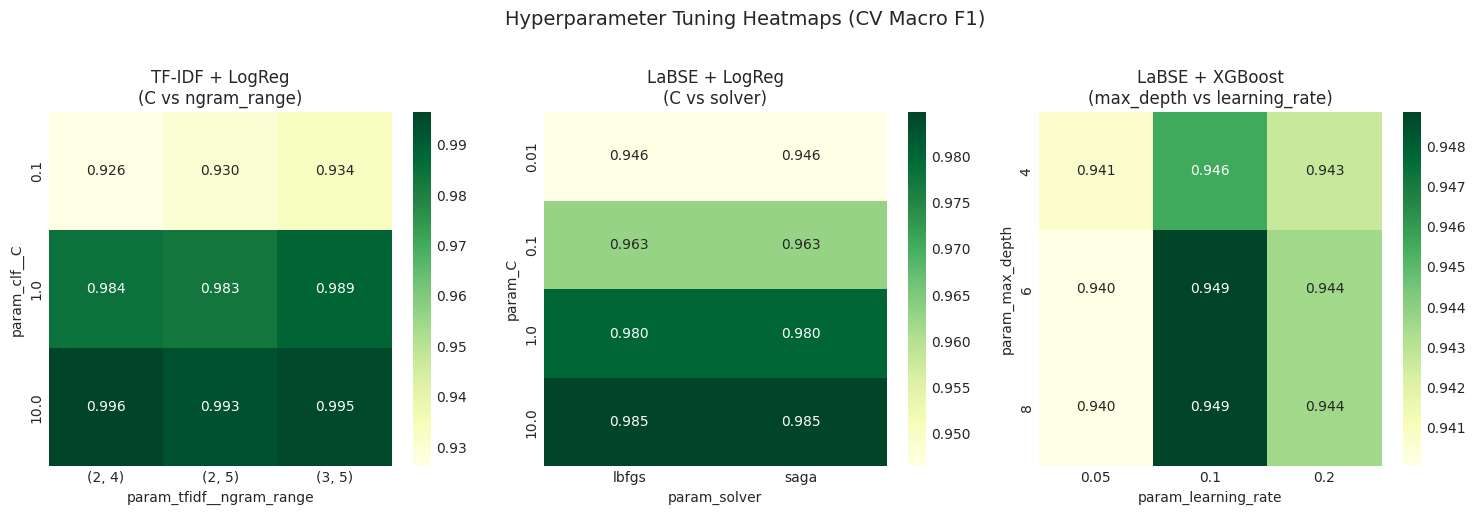

In [49]:
# Visualize tuning results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# TF-IDF tuning results
tfidf_results = pd.DataFrame(tfidf_grid.cv_results_)
tfidf_pivot = tfidf_results.pivot_table(
    values='mean_test_score', 
    index='param_clf__C', 
    columns='param_tfidf__ngram_range'
)
sns.heatmap(tfidf_pivot, annot=True, fmt='.3f', cmap='YlGn', ax=axes[0])
axes[0].set_title('TF-IDF + LogReg\n(C vs ngram_range)')

# LaBSE + LogReg tuning results
labse_lr_results = pd.DataFrame(labse_lr_grid.cv_results_)
labse_lr_pivot = labse_lr_results.pivot_table(
    values='mean_test_score', 
    index='param_C', 
    columns='param_solver'
)
sns.heatmap(labse_lr_pivot, annot=True, fmt='.3f', cmap='YlGn', ax=axes[1])
axes[1].set_title('LaBSE + LogReg\n(C vs solver)')

# LaBSE + XGBoost tuning results
labse_xgb_results = pd.DataFrame(labse_xgb_grid.cv_results_)
labse_xgb_pivot = labse_xgb_results.pivot_table(
    values='mean_test_score', 
    index='param_max_depth', 
    columns='param_learning_rate'
)
sns.heatmap(labse_xgb_pivot, annot=True, fmt='.3f', cmap='YlGn', ax=axes[2])
axes[2].set_title('LaBSE + XGBoost\n(max_depth vs learning_rate)')

plt.suptitle('Hyperparameter Tuning Heatmaps (CV Macro F1)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Final Evaluation on Held-Out Test Set

Now we train on the full training set and evaluate on the test set (first time touching test data).

In [50]:
# Generate test embeddings
print("Generating embeddings for test data...")
X_test_emb = encoder.encode(X_test.tolist(), show_progress_bar=True)
print(f"Test embeddings shape: {X_test_emb.shape}")

Generating embeddings for test data...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Test embeddings shape: (69, 768)


In [ ]:
# Final evaluation using best models from GridSearchCV
print("Final Evaluation on Test Set using Best Tuned Models")

# 1. TF-IDF + LogReg (already fitted during GridSearchCV)
tfidf_test_pred = tfidf_best_model.predict(X_test)
tfidf_test_f1 = f1_score(y_test, tfidf_test_pred, average='macro')
tfidf_test_acc = accuracy_score(y_test, tfidf_test_pred)

# 2. LaBSE + LogReg (already fitted during GridSearchCV)
labse_lr_test_pred = labse_lr_best_model.predict(X_test_emb)
labse_lr_test_f1 = f1_score(y_test, labse_lr_test_pred, average='macro')
labse_lr_test_acc = accuracy_score(y_test, labse_lr_test_pred)

# 3. LaBSE + XGBoost (already fitted during GridSearchCV)
labse_xgb_test_pred = le.inverse_transform(labse_xgb_best_model.predict(X_test_emb))
labse_xgb_test_f1 = f1_score(y_test, labse_xgb_test_pred, average='macro')
labse_xgb_test_acc = accuracy_score(y_test, labse_xgb_test_pred)

print("Done!")

Final Evaluation on Test Set using Best Tuned Models
Done!


In [ ]:
# Final comparison
print("FINAL TEST SET EVALUATION")
print(f"\n{'Model':<25} {'CV F1 (mean)':<15} {'Test Acc':<12} {'Test F1':<12}")
print(f"{'TF-IDF + LogReg':<25} {tfidf_cv_f1:<15.4f} {tfidf_test_acc:<12.4f} {tfidf_test_f1:<12.4f}")
print(f"{'LaBSE + LogReg':<25} {labse_lr_cv_f1:<15.4f} {labse_lr_test_acc:<12.4f} {labse_lr_test_f1:<12.4f}")
print(f"{'LaBSE + XGBoost':<25} {labse_xgb_cv_f1:<15.4f} {labse_xgb_test_acc:<12.4f} {labse_xgb_test_f1:<12.4f}")

FINAL TEST SET EVALUATION

Model                     CV F1 (mean)    Test Acc     Test F1     
-----------------------------------------------------------------
TF-IDF + LogReg           0.9964          0.9855       0.9860      
LaBSE + LogReg            0.9848          0.9710       0.9729      
LaBSE + XGBoost           0.9501          0.9275       0.9195      
-----------------------------------------------------------------


In [ ]:
# Per-language breakdown on test set
print("\nTest Set Accuracy by Language:")

test_df_eval = test_df.copy()
test_df_eval['tfidf_pred'] = tfidf_test_pred
test_df_eval['labse_lr_pred'] = labse_lr_test_pred
test_df_eval['labse_xgb_pred'] = labse_xgb_test_pred

print(f"\n{'Language':<12} {'TF-IDF+LR':<15} {'LaBSE+LR':<15} {'LaBSE+XGB':<15} {'Samples':<10}")

for lang in test_df_eval['language'].unique():
    subset = test_df_eval[test_df_eval['language'] == lang]
    tfidf_acc = (subset['tfidf_pred'] == subset['intent']).mean()
    labse_lr_acc = (subset['labse_lr_pred'] == subset['intent']).mean()
    labse_xgb_acc = (subset['labse_xgb_pred'] == subset['intent']).mean()
    print(f"{lang:<12} {tfidf_acc:<15.4f} {labse_lr_acc:<15.4f} {labse_xgb_acc:<15.4f} {len(subset):<10}")


Test Set Accuracy by Language:

Language     TF-IDF+LR       LaBSE+LR        LaBSE+XGB       Samples   
-----------------------------------------------------------------
rw           0.9744          0.9744          0.9231          39        
en           1.0000          0.9524          0.9048          21        
mixed        1.0000          1.0000          1.0000          9         


## Conclusions

In [ ]:
# Compare CV score vs Test score
print("OVERFITTING DIAGNOSIS")

# TF-IDF predictions
y_train_pred_tfidf = tfidf_best_model.predict(X_train)
y_test_pred_tfidf = tfidf_best_model.predict(X_test)

tfidf_train_f1 = f1_score(y_train, y_train_pred_tfidf, average='macro')
tfidf_test_f1 = f1_score(y_test, y_test_pred_tfidf, average='macro')

print(f"TF-IDF + LogReg:")
print(f"  Train F1: {tfidf_train_f1:.4f}")
print(f"  CV F1:    {tfidf_cv_f1:.4f}")
print(f"  Test F1:  {tfidf_test_f1:.4f}")
print(f"  Gap (CV - Test): {tfidf_cv_f1 - tfidf_test_f1:.4f}")

# LaBSE + LogReg predictions
y_train_pred_labse = labse_lr_best_model.predict(X_train_emb)
y_test_pred_labse = labse_lr_best_model.predict(X_test_emb)

labse_lr_train_f1 = f1_score(y_train, y_train_pred_labse, average='macro')
labse_lr_test_f1 = f1_score(y_test, y_test_pred_labse, average='macro')

print(f"\nLaBSE + LogReg:")
print(f"  Train F1: {labse_lr_train_f1:.4f}")
print(f"  CV F1:    {labse_lr_cv_f1:.4f}")
print(f"  Test F1:  {labse_lr_test_f1:.4f}")
print(f"  Gap (CV - Test): {labse_lr_cv_f1 - labse_lr_test_f1:.4f}")

# LaBSE + XGBoost predictions
y_train_pred_xgb = labse_xgb_best_model.predict(X_train_emb)
y_test_pred_xgb = labse_xgb_best_model.predict(X_test_emb)

labse_xgb_train_f1 = f1_score(y_train_enc, y_train_pred_xgb, average='macro')
labse_xgb_test_f1 = f1_score(y_test_enc, y_test_pred_xgb, average='macro')

print(f"\nLaBSE + XGBoost:")
print(f"  Train F1: {labse_xgb_train_f1:.4f}")
print(f"  CV F1:    {labse_xgb_cv_f1:.4f}")
print(f"  Test F1:  {labse_xgb_test_f1:.4f}")
print(f"  Gap (CV - Test): {labse_xgb_cv_f1 - labse_xgb_test_f1:.4f}")

# Summary Table
print("SUMMARY COMPARISON")
print(f"{'Model':<25} {'Train F1':>10} {'CV F1':>10} {'Test F1':>10} {'Gap':>8}")
print(f"{'TF-IDF + LogReg':<25} {tfidf_train_f1:>10.4f} {tfidf_cv_f1:>10.4f} {tfidf_test_f1:>10.4f} {tfidf_cv_f1 - tfidf_test_f1:>8.4f}")
print(f"{'LaBSE + LogReg':<25} {labse_lr_train_f1:>10.4f} {labse_lr_cv_f1:>10.4f} {labse_lr_test_f1:>10.4f} {labse_lr_cv_f1 - labse_lr_test_f1:>8.4f}")
print(f"{'LaBSE + XGBoost':<25} {labse_xgb_train_f1:>10.4f} {labse_xgb_cv_f1:>10.4f} {labse_xgb_test_f1:>10.4f} {labse_xgb_cv_f1 - labse_xgb_test_f1:>8.4f}")

OVERFITTING DIAGNOSIS
TF-IDF + LogReg:
  Train F1: 0.9988
  CV F1:    0.9964
  Test F1:  0.9860
  Gap (CV - Test): 0.0104

LaBSE + LogReg:
  Train F1: 0.9988
  CV F1:    0.9848
  Test F1:  0.9729
  Gap (CV - Test): 0.0118

LaBSE + XGBoost:
  Train F1: 1.0000
  CV F1:    0.9501
  Test F1:  0.9195
  Gap (CV - Test): 0.0306

SUMMARY COMPARISON
Model                       Train F1      CV F1    Test F1      Gap
------------------------------------------------------------
TF-IDF + LogReg               0.9988     0.9964     0.9860   0.0104
LaBSE + LogReg                0.9988     0.9848     0.9729   0.0118
LaBSE + XGBoost               1.0000     0.9501     0.9195   0.0306

INTERPRETATION

Gap Guidelines (CV - Test):
  < 2%:  No overfitting ✅
  2-5%:  Mild overfitting, acceptable ⚠️
  5-10%: Moderate overfitting, concerning ❌
  > 10%: Severe overfitting 🚨

What to look for:
  - Train F1 ≈ 100% but Test F1 < 90% → Memorization problem
  - CV F1 ≈ Test F1 → Good generalization
  - CV F1 >> Tes

## Save prefered model

In [59]:
os.makedirs('../models', exist_ok=True)
joblib.dump(labse_lr_best_model, '../models/labse_logreg_classifier.joblib')
print("Saved: models/labse_logreg_classifier.joblib")

Saved: models/labse_logreg_classifier.joblib


In [61]:
# Save LaBSE model info (for loading sentence-transformers later)
model_info = {
    'embedding_model': 'sentence-transformers/LaBSE',
    'embedding_dim': 768,
    'classifier': 'LogisticRegression',
    'best_params': labse_lr_grid.best_params_,
    'cv_f1': labse_lr_cv_f1,
    'test_f1': labse_lr_test_f1,
    'classes': list(labse_lr_best_model.classes_)
}
joblib.dump(model_info, '../models/labse_logreg_info.joblib')
print("Saved: models/labse_logreg_info.joblib")

Saved: models/labse_logreg_info.joblib
